# Solutions for block G

In [1]:
import geopandas
import contextily
from libpysal import examples
import seaborn as sns
import pandas as pd
from libpysal import weights
import matplotlib.pyplot as plt
from sklearn import cluster



```{admonition} Note
:class: tip

The solutions provided below is more advanced and is included here for illustration purposes but you are not required to learn it step by step if it looks too complicated. There are alternative, manual approaches that would be just as effective in this context
```

## Task I


- Load data from PySAL examples

In [2]:
# Load example (this automatically downloads if not available)
nyc_data = examples.load_example("NYC Socio-Demographics")
nyc = geopandas.read_file(nyc_data.get_path("NYC_Tract_ACS2008_12.shp"))

- Variables to be used for the classification

In [3]:
# Create a list of the columns we will use to calculate ethnicity
ethnicity = [
    'european', 
    'asian', 
    'american', 
    'african',
    'hispanic', 
    'mixed', 
    'pacific'
]

- Make sure you standardise the table by the size of each tract

In [4]:
# Create % of each ethnicity
pcts = nyc[ethnicity].divide(nyc["poptot"], axis=0) * 100
# Join % to main table
nyc = nyc.join(pcts, rsuffix="_pct")

Now, to keep it handy, we can create a sister list of `ethnicity` with the `_pct` suffix:


In [5]:
ethnicity_pcts = [i + "_pct" for i in ethnicity]

In [6]:
nyc[ethnicity_pcts].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2166 entries, 0 to 2165
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   european_pct  2126 non-null   float64
 1   asian_pct     2126 non-null   float64
 2   american_pct  2126 non-null   float64
 3   african_pct   2126 non-null   float64
 4   hispanic_pct  2126 non-null   float64
 5   mixed_pct     2126 non-null   float64
 6   pacific_pct   2126 non-null   float64
dtypes: float64(7)
memory usage: 118.6 KB


We drop from the analysis areas with zero population (and thus missing data in the percentages)

In [7]:
# Keep only pct variables and the geometry of the polygon
nyc_to_cluster = nyc[ethnicity_pcts + ["geometry"]]\
                    .dropna()# Drop rows with missing data

- Clustering of percentages in ten groups

In [8]:
#Set up a kmeans with 10 clusters
kmeans5 = cluster.KMeans(n_clusters=10, random_state=12345)
# Run the clustering algorithm
k5cls = kmeans5.fit(nyc_to_cluster[ethnicity_pcts])
#Add labels to as a column
nyc_to_cluster['k5cls'] = k5cls.labels_

- Map clusters geographically

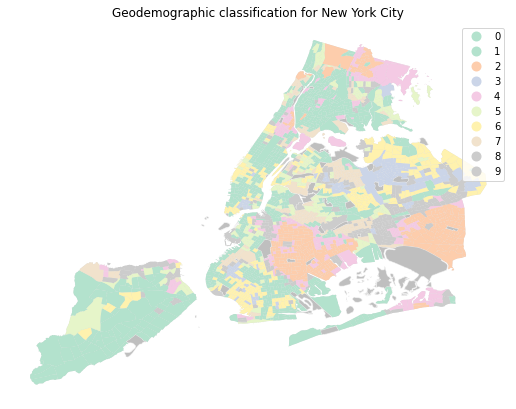

In [9]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot underlying geometries of all areas 
#in light grey and white borders
nyc.plot(ax=ax, 
         facecolor="grey", 
         edgecolor="w", 
         alpha=0.5
        )
# Plot unique values choropleth including 
#a legend and with no boundary lines
nyc_to_cluster.plot(column='k5cls', 
                    categorical=True, 
                    cmap="Pastel2",
                    legend=True, 
                    linewidth=0, 
                    ax=ax
                   )
# Remove axis
ax.set_axis_off()
# Add title
plt.title('Geodemographic classification for New York City')
# Display the map
plt.show()

- Main characteristics of each cluster: size

In [10]:
k5sizes = nyc_to_cluster.groupby('k5cls').size()
k5sizes

k5cls
0    250
1    447
2    308
3    108
4    196
5    173
6    251
7    171
8    133
9     89
dtype: int64

- Main characteristics of each cluster: averages

In [11]:
# Calculate the mean for each cluster
k5means = nyc_to_cluster.groupby('k5cls')[ethnicity_pcts].mean()
k5means.index.name = "Clusters"
k5means.columns.name = "Variables"
# Show the table transposed (so it's not too wide)
k5means.T

Clusters,0,1,2,3,4,5,6,7,8,9
Variables,,,,,,,,,,
european_pct,18.752326,86.554358,5.516806,27.743508,15.764396,69.421973,62.327378,45.842677,26.446354,46.738692
asian_pct,2.762427,6.614401,2.070764,60.920286,4.349999,9.562917,27.401376,10.109675,34.701930,6.356698
american_pct,0.579411,0.241241,0.235771,0.638329,0.403882,0.306859,0.246763,0.546820,1.024521,0.297679
african_pct,31.599543,2.437386,86.367272,3.247220,61.414369,5.603461,3.138788,10.718923,12.741864,33.873795
hispanic_pct,66.087596,9.544785,8.601853,13.353731,26.652351,32.211810,13.039138,66.021427,31.969973,23.066936
mixed_pct,3.997062,1.729249,1.722985,2.225277,3.460053,2.862650,2.255141,3.342279,4.913240,3.420152
pacific_pct,0.026150,0.019847,0.072483,0.043323,0.061675,0.026276,0.080706,0.057817,0.125435,0.005759


## Task II

In [12]:
# Read the file in
db = geopandas.read_file("http://darribas.org/gds_course/content/data/dar_es_salaam.geojson")

1. Create a spatial weights matrix to capture spatial relationships between hexagons

In [13]:
w = weights.Queen.from_dataframe(db)

/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 87.
  warnings.warn(message)


We see there is an island. It is not compulsory but, if we don't remove the island, a full cluster will be "used up" on that one observation.

In [14]:
db_to_cluster = db.drop(w.islands)

Then we need to re-build the spatial weights matrix to not include the island:

In [15]:
w = weights.Queen.from_dataframe(db_to_cluster)
w.islands

/opt/conda/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


[]

To make it easier on the clustering, grab the variables used in the regionalisation:

In [16]:
vars_to_cluster = [
    "street_length",
    "street_linearity",
    "building_density",
    "building_coverage"
]

2. Set up a regionalisation algorithm with a given number of clusters (e.g. seven)

In [17]:
sagg7 = cluster.AgglomerativeClustering(n_clusters=7, connectivity=w.sparse)
sagg7

AgglomerativeClustering(connectivity=<1290x1290 sparse matrix of type '<class 'numpy.float64'>'
	with 7076 stored elements in Compressed Sparse Row format>,
                        n_clusters=7)

And we compute the regionalisation:

In [18]:
# Run the clustering algorithm
sagg7cls = sagg7.fit(db_to_cluster[vars_to_cluster])

/opt/conda/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:247: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


3. Generate a geography that contains only the boundaries of each region and visualise it (ideally with a satellite image as basemap for context)

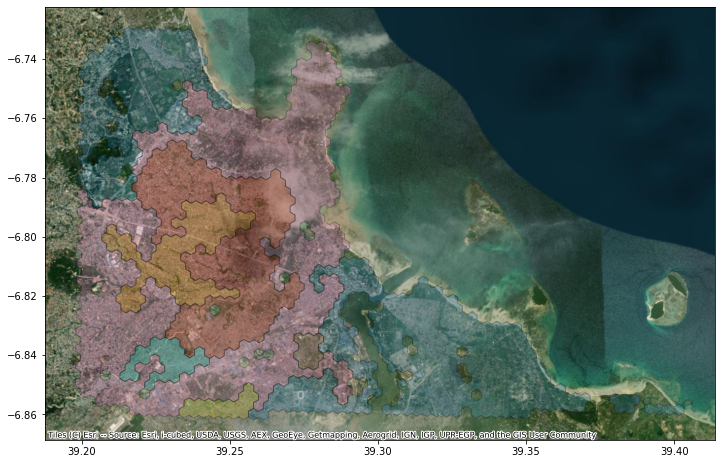

In [19]:
ax = db_to_cluster.assign(labels=sagg7cls.labels_)\
                  .dissolve("labels")\
                  .reset_index()\
                  .plot(column="labels",
                        edgecolor="black",
                        alpha=0.25,
                        categorical=True,
                        figsize=(12, 12)
                       )
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Esri.WorldImagery
                      )

4. Rinse and repeat with several combinations of variables and number of clusters

5. Pick your best. Why have you selected it? What does it show? What are the main groups of areas based on the built environment?

> These are left up to the student to select their own combinations of variables and clusters. The logic to build each of them can be directly applied from code presented above